In [31]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Load and filter scraped GTA vehicle data

In [63]:
df_gta = pd.read_csv('data/vehicle_data.tsv',  sep='\t', index_col=0)
df_gta.head()

,Acceleration,Available from,Braking,Default Radio Stations,Discounted Price,Drive Train,Game Edition,Gears,Handling,Manufacturer,...,Sell,Sell Price - Resale,Sell Price - Stolen,Speed,Storage Location,Title Update,Top Speed,Variants,Vehicle Class,Vehicle Features
akula.html,100.0,Warstock Cache & Carry,NaN,NaN,2785000.0,NaN,GTA Online - Next Gen,NaN,100.00,NaN,...,Can be sold only if purchased (High-End),2222430.0,NaN,76.75,Hangar (Personal Aircraft),1.42 The Doomsday Heist,160.0,NaN,Helicopters,Armed Vehicle
albany-alpha.html,85.0,Legendary Motorsport,33.33,"Radio Los Santos, The Lab, West Coast Classics",NaN,RWD,All Editions,6.0,77.27,Albany,...,Can be sold only if purchased (High-End),90000.0,NaN,83.17,Garage (Personal Vehicle),1.11 Business,150.0,NaN,Sports,NaN
albany-buccaneer-custom.html,70.0,Benny's Original Motor Works,26.67,NaN,NaN,RWD,GTA Online - Next Gen,5.0,65.15,Albany,...,Can be sold only if purchased (High-End),234000.0,NaN,78.34,Garage (Personal Vehicle),1.30 Lowriders,146.0,NaN,Muscle,Custom Vehicle
albany-buccaneer.html,70.0,"Can be stolen / found, Benny's Original Motor ...",26.67,Channel X,NaN,RWD,All Editions,5.0,65.15,Albany,...,Can be sold if purchased or stolen,17400.0,2900.0,78.34,Garage (Personal Vehicle),1.01 Game Launch,146.0,Gang Variants (Cannot be purchased),Muscle,NaN
albany-cavalcade-ii.html,50.0,"Can be stolen / found, Southern S.A. Super Autos",20.00,NaN,NaN,AWD,All Editions,4.0,57.58,Albany,...,Can be sold if purchased or stolen,42000.0,7000.0,68.14,Garage (Personal Vehicle),1.01 Game Launch,127.0,NaN,SUVs,NaN


In [64]:
df_gta.shape

(568, 26)

### Impute missing purchase prices based on selling prices 
- Resale Price = 0.6 * Purchase Price
- Resale Price = 6.0 * Stolen Price

Slope: 6.000000000000004
Intercept: -1.4551915228366852e-11
R2: 1.0


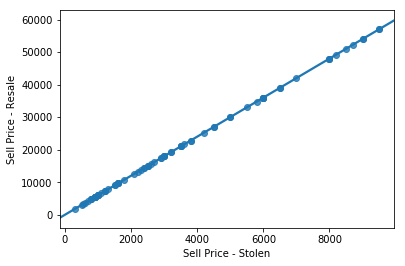

In [65]:
sns.regplot(x='Sell Price - Stolen', y='Sell Price - Resale', data=df_gta)

df_price_data = df_gta.reindex(columns=['Sell Price - Stolen', 'Sell Price - Resale'])
df_price_data.dropna(inplace=True)
stolen_prices = df_price_data.values[:,0]
resale_prices = df_price_data.values[:,1]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(stolen_prices, resale_prices)
print('Slope:', slope)
print('Intercept:', intercept)
print('R2:', r_value ** 2)

Slope: 0.6000315791210591
Intercept: -100.16515402967343
R2: 0.9999967608064512


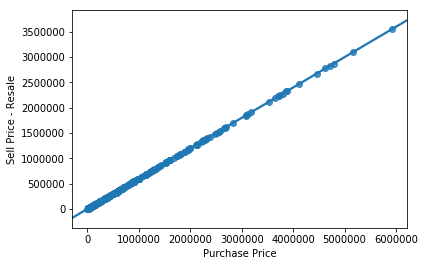

In [66]:
sns.regplot(x='Purchase Price', y='Sell Price - Resale', data=df_gta)

df_price_data = df_gta.reindex(columns=['Purchase Price', 'Sell Price - Resale'])
df_price_data.dropna(inplace=True)
purchase_prices = df_price_data.values[:,0]
resale_prices = df_price_data.values[:,1]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(purchase_prices, resale_prices)
print('Slope:', slope)
print('Intercept:', intercept)
print('R2:', r_value ** 2)

In [67]:
''' Imputing the three price values using these relationships'''
df_prices = df_gta.reindex(columns=['Purchase Price', 'Sell Price - Resale', 'Sell Price - Stolen'])
prices = []
for purchase, resale, stolen in df_prices.itertuples(name=None, index=False):
    if pd.notnull(purchase):
        priceset = (purchase, purchase * 0.6, purchase * 0.1)
    elif pd.notnull(resale):
        priceset = (resale / 0.6, resale, resale / 6.0)
    elif pd.notnull(stolen):
        priceset = (stolen * 10.0, stolen * 6.0, stolen)
    else:
        priceset = (np.nan, np.nan, np.nan)
    prices.append(priceset)

prices = np.array(prices)
df_gta['Purchase Price'] = prices[:,0]
df_gta['Sell Price - Resale'] = prices[:,1]
df_gta['Sell Price - Stolen'] = prices[:,2]

In [90]:
''' Finally, update the free gift vehicle to its in-game price '''
df_gta.at['annis-elegy-rh8.html','Purchase Price'] = 95000.0
df_gta.at['annis-elegy-rh8.html','Sell Price - Resale'] = 95000.0 * 0.6
df_gta.at['annis-elegy-rh8.html','Sell Price - Stolen'] = 95000.0 * 0.1

### Limit to civilian vehicles (filter by "Vehicle Class" and "Vehicle Features")

In [91]:
civilian_vehicle_classes = ['Compacts', 'Coupes', 'Off-Road', 'Off-Road, SUVs', 'Off-Road, Vans', 'SUVs',
                            'Sedans', 'Sedans, Sports', 'Sports', 'Sports Classic', 'Super', 'Vans'] # include only these
non_civilian_features = ['Armed Vehicle', 'Armored Vehicle', 'Weaponized Vehicle', 'Special Vehicle', 
                         'Remote Controlled Vehicle'] # exclude any of these

df_gta_civ = df_gta[df_gta.loc[:,'Vehicle Class'].map(
    lambda cls: cls in civilian_vehicle_classes)]
df_gta_civ = df_gta_civ[df_gta_civ.loc[:,'Vehicle Features'].map(
    lambda features: pd.isnull(features) or all(map(lambda feat: not feat in features, non_civilian_features)))]

print(df_gta_civ.shape)

(254, 26)


# 1. Comparing Price vs. Top Speed/Speed/Accel/Braking/Handling/Overall

In [117]:
df_stats = df_gta_civ.reindex(columns=['Purchase Price', 'Top Speed', 'Speed', 'Acceleration', 'Braking', 'Handling', 'Overall'])
df_stats.dropna(inplace=True)
print(df_stats.shape)
df_stats.head()

(237, 7)


,Purchase Price,Top Speed,Speed,Acceleration,Braking,Handling,Overall
albany-alpha.html,150000.0,150.0,83.17,85.00,33.33,77.27,69.69
albany-cavalcade-ii.html,70000.0,127.0,68.14,50.00,20.00,57.58,48.93
albany-cavalcade.html,60000.0,127.0,68.14,50.00,20.00,57.58,48.93
albany-emperor.html,8000.0,120.0,64.39,35.00,20.00,57.58,44.24
albany-franken-stange.html,550000.0,135.0,72.43,88.75,18.33,58.79,59.58


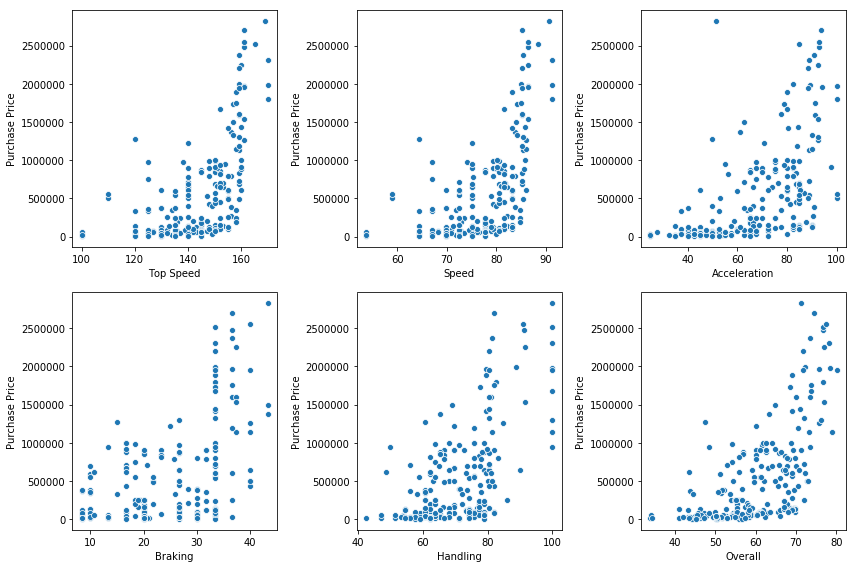

In [118]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
axs = axs.flatten()

attributes = ['Top Speed', 'Speed', 'Acceleration', 'Braking', 'Handling', 'Overall']
for i,ax in enumerate(axs):
    attr = attributes[i]
    sns.scatterplot(x=attr, y='Purchase Price', data=df_stats, ax=ax)
plt.tight_layout()

In [119]:
df_stats['Log Price'] = np.log10(df_stats['Purchase Price'].values)

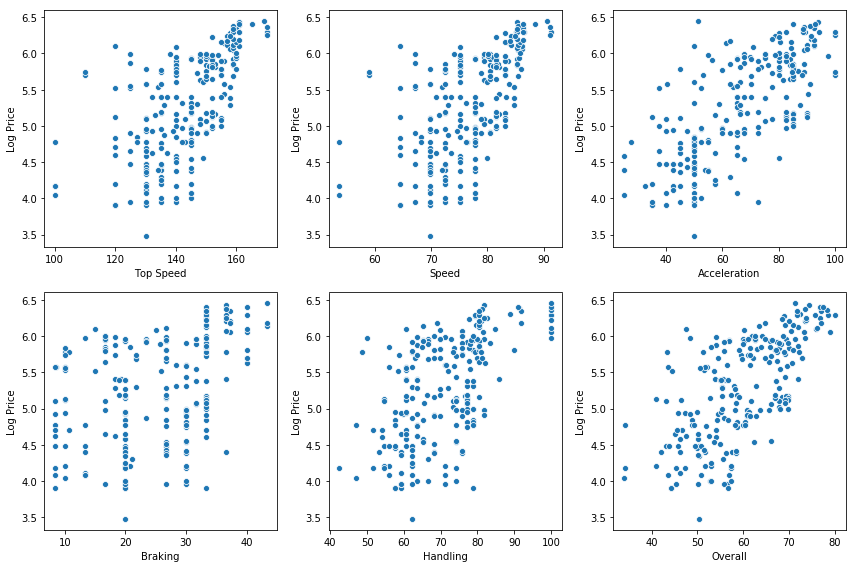

In [120]:
fig, axs = plt.subplots(2,3,figsize=(12,8))
axs = axs.flatten()

attributes = ['Top Speed', 'Speed', 'Acceleration', 'Braking', 'Handling', 'Overall']
for i,ax in enumerate(axs):
    attr = attributes[i]
    sns.scatterplot(x=attr, y='Log Price', data=df_stats, ax=ax)
plt.tight_layout()

# 2. Train a regressor to predict price from these attributes

In [121]:
from sklearn.linear_model import LinearRegression

In [131]:
''' Since all attributes are 0-100 except Top Speed, only normalization will be 
    scaling Top Speed to 0-100, then dividing by 100 to get everything to 0-1.
    Will also ignore Overall (simple average of other attributes), and aim
    to predict the log10 price. '''

top_speeds = df_stats['Top Speed'].values.astype(float)
df_stats['Norm Top Speed'] = top_speeds / np.nanmax(df_stats['Top Speed'].values) * 100.0

X = df_stats.reindex(columns=['Norm Top Speed', 'Speed', 'Acceleration', 'Braking', 'Handling'])
X = X.transform(lambda x: x/100.0)
y = df_stats['Log Price']

Text(0,0.5,'Log Price (fit)')

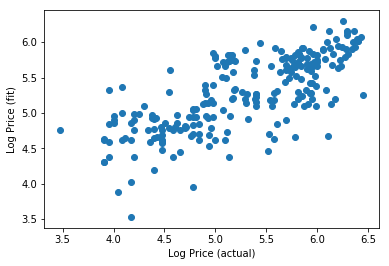

In [132]:
linreg = LinearRegression(fit_intercept=True, normalize=False)
linreg.fit(X,y)
y_predict = linreg.predict(X)

plt.scatter(y,y_predict)
plt.xlabel('Log Price (actual)')
plt.ylabel('Log Price (fit)')

In [133]:
linreg.coef_

array([ 6.52398918, -4.91480728,  2.11799061, -0.86837107,  0.5351355 ])